In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial

In [23]:
## Imports for plotting
import matplotlib.pyplot as plt

from transformers_multihead_attn_tutorial.data.reverse_dataset import ReverseDataset
from transformers_multihead_attn_tutorial.model.positional_encoding import PositionalEncoding
from transformers_multihead_attn_tutorial.model.scaled_dot_product import scaled_dot_product
from transformers_multihead_attn_tutorial.training.cosine_warmup_scheduler import CosineWarmupScheduler
from transformers_multihead_attn_tutorial.training.train_reverse import train_reverse
from transformers_multihead_attn_tutorial.data.set_anomaly_dataset import SetAnomalyDataset
from transformers_multihead_attn_tutorial.training.train_anomaly import train_anomaly

plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()


Device: cuda:0


In [4]:
## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms


In [5]:
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install pytorch-lightning==1.3.4
    import pytorch_lightning as pl


In [6]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



Global seed set to 42


In [7]:
## Scaled Dot Product Test

In [7]:
seq_len, d_k = 3, 2
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)

values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Q
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]])
K
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]])
V
 tensor([[ 1.1103, -1.6898],
        [-0.9890,  0.9580],
        [ 1.3221,  0.8172]])
Values
 tensor([[ 0.5439, -0.0978],
        [ 0.5215, -0.0104],
        [ 0.2890,  0.4370]])
Attention
 tensor([[0.3819, 0.3017, 0.3163],
        [0.3478, 0.3145, 0.3377],
        [0.1759, 0.4309, 0.3932]])


In [9]:
## Visualizing Positional Encodings

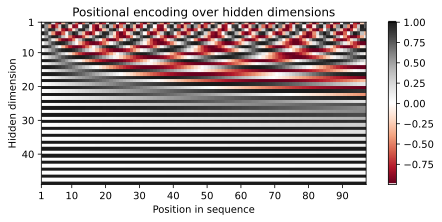

In [8]:
encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

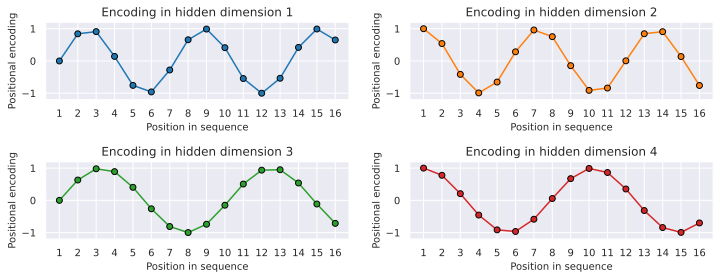

In [9]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color='C%i'%i, marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title("Encoding in hidden dimension %i" % (i+1))
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

In [12]:
## Cosine LR Scheduler Visualization

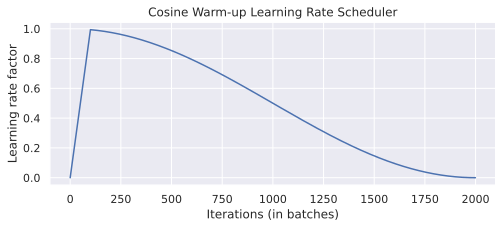

In [10]:
# Needed for initializing the lr scheduler
p = nn.Parameter(torch.empty(4,4))
optimizer = optim.Adam([p], lr=1e-3)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

In [ ]:
# REVERSE TASK

In [14]:
## Dataset Creation

In [15]:
dataset = partial(ReverseDataset, 10, 16) # Very good partial usage
train_loader = data.DataLoader(dataset(50000), batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader   = data.DataLoader(dataset(1000), batch_size=128)
test_loader  = data.DataLoader(dataset(10000), batch_size=128)


In [16]:
inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)


Input data: tensor([9, 6, 2, 0, 6, 2, 7, 9, 7, 3, 3, 4, 3, 7, 0, 9])
Labels:     tensor([9, 0, 7, 3, 4, 3, 3, 7, 9, 7, 2, 6, 0, 2, 6, 9])


In [23]:
reverse_model, reverse_result = train_reverse(model_name="ReverseTask",
                                              train_loader=train_loader,
                                              test_loader=test_loader,
                                              val_loader=val_loader,
                                              input_dim=train_loader.dataset.num_categories,
                                              model_dim=32,
                                              num_heads=2,
                                              num_classes=train_loader.dataset.num_categories,
                                              num_layers=1,
                                              dropout=0.0,
                                              lr=5e-4,
                                              warmup=50)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | input_net           | Sequential         | 352   
1 | positional_encoding | PositionalEncoding | 0     
2 | transformer         | TransformerEncoder | 8.5 K 
3 | output_net          | Sequential         | 1.4 K 
-----------------------------------------------------------
10.3 K    Trainable params
0         Non-trainable params
10.3 K    Total params
0.041     Total estimated model params size (MB)


/home/gsoykan20/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Global seed set to 42
/home/gsoykan20/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/gsoykan20/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [24]:
print("Val accuracy:  %4.2f%%" % (100.0 * reverse_result["val_acc"]))
print("Test accuracy: %4.2f%%" % (100.0 * reverse_result["test_acc"]))

Val accuracy:  98.90%
Test accuracy: 98.94%


In [25]:
# Attention Map Checking and Visualization

In [26]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
data_input, labels = next(iter(val_loader))
inp_data = F.one_hot(data_input, num_classes=reverse_model.hparams.num_classes).float()
inp_data = inp_data.to(device)
attention_maps = reverse_model.get_attention_maps(inp_data)

In [27]:
attention_maps[0].shape


torch.Size([128, 2, 16, 16])

In [31]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title("Layer %i, Head %i" % (row+1, column+1))
    fig.subplots_adjust(hspace=0.5)
    plt.show()


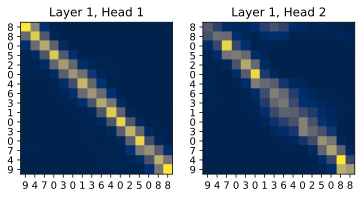

In [29]:
plot_attention_maps(data_input, attention_maps, idx=0)


In [11]:
# ImageNet statistics
DATA_MEANS = np.array([0.485, 0.456, 0.406])
DATA_STD = np.array([0.229, 0.224, 0.225])
# As torch tensors for later preprocessing
TORCH_DATA_MEANS = torch.from_numpy(DATA_MEANS).view(1,3,1,1)
TORCH_DATA_STD = torch.from_numpy(DATA_STD).view(1,3,1,1)

# Resize to 224x224, and normalize to ImageNet statistic
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(DATA_MEANS, DATA_STD)
                                ])
# Loading the training dataset.
train_set = CIFAR100(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = CIFAR100(root=DATASET_PATH, train=False, transform=transform, download=True)


Extracting ../data/cifar-100-python.tar.gz to ../data
Files already downloaded and verified


In [ ]:
## EXTRACT CIFAR100 IMAGE FEATURES AND SAVE

In [12]:
CHECKPOINT_PATH = "../saved_models/tutorial6"
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(pretrained=True)

# Remove classification layer
# In some models, it is called "fc", others have "classifier"
# Setting both to an empty sequential represents an identity map of the final features.
pretrained_model.fc = nn.Sequential()
pretrained_model.classifier = nn.Sequential()

# To GPU
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
pretrained_model = pretrained_model.to(device)

# Only eval, no gradient required
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to ../saved_models/tutorial6/hub/checkpoints/resnet34-333f7ec4.pth


In [13]:
@torch.no_grad()
def extract_features(dataset, save_file):
    if not os.path.isfile(save_file):
        data_loader = data.DataLoader(dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
        extracted_features = []
        for imgs, _ in tqdm(data_loader):
            imgs = imgs.to(device)
            feats = pretrained_model(imgs)
            extracted_features.append(feats)
        extracted_features = torch.cat(extracted_features, dim=0)
        extracted_features = extracted_features.detach().cpu()
        torch.save(extracted_features, save_file)
    else:
        extracted_features = torch.load(save_file)
    return extracted_features

In [14]:
train_feat_file = os.path.join(CHECKPOINT_PATH, "train_set_features.tar")
train_set_feats = extract_features(train_set, train_feat_file)

test_feat_file = os.path.join(CHECKPOINT_PATH, "test_set_features.tar")
test_feats = extract_features(test_set, test_feat_file)

In [15]:
print("Train:", train_set_feats.shape)
print("Test: ", test_feats.shape)

Train: torch.Size([50000, 512])
Test:  torch.Size([10000, 512])


In [16]:
## Split train into train+val
# Get labels from train set
labels = train_set.targets

# Get indices of images per class
labels = torch.LongTensor(labels)
num_labels = labels.max()+1
sorted_indices = torch.argsort(labels).reshape(num_labels, -1) # [classes, num_imgs per class]

# Determine number of validation images per class
num_val_exmps = sorted_indices.shape[1] // 10

# Get image indices for validation and training
val_indices   = sorted_indices[:,:num_val_exmps].reshape(-1)
train_indices = sorted_indices[:,num_val_exmps:].reshape(-1)

# Group corresponding image features and labels
train_feats, train_labels = train_set_feats[train_indices], labels[train_indices]
val_feats,   val_labels   = train_set_feats[val_indices],   labels[val_indices]

In [19]:
SET_SIZE = 10
test_labels = torch.LongTensor(test_set.targets)

train_anom_dataset = SetAnomalyDataset(train_feats, train_labels, set_size=SET_SIZE, train=True)
val_anom_dataset   = SetAnomalyDataset(val_feats,   val_labels,   set_size=SET_SIZE, train=False)
test_anom_dataset  = SetAnomalyDataset(test_feats,  test_labels,  set_size=SET_SIZE, train=False)

train_anom_loader = data.DataLoader(train_anom_dataset, batch_size=64, shuffle=True,  drop_last=True,  num_workers=4, pin_memory=True)
val_anom_loader   = data.DataLoader(val_anom_dataset,   batch_size=64, shuffle=False, drop_last=False, num_workers=4)
test_anom_loader  = data.DataLoader(test_anom_dataset,  batch_size=64, shuffle=False, drop_last=False, num_workers=4)

In [21]:
def visualize_exmp(indices, orig_dataset):
    images = [orig_dataset[idx][0] for idx in indices.reshape(-1)]
    images = torch.stack(images, dim=0)
    images = images * TORCH_DATA_STD + TORCH_DATA_MEANS

    img_grid = torchvision.utils.make_grid(images,
                                           nrow=SET_SIZE,
                                           normalize=True,
                                           pad_value=0.5,
                                           padding=16)
    img_grid = img_grid.permute(1, 2, 0)

    plt.figure(figsize=(12,8))
    plt.title("Anomaly examples on CIFAR100")
    plt.imshow(img_grid)
    plt.axis('off')
    plt.show()
    plt.close()

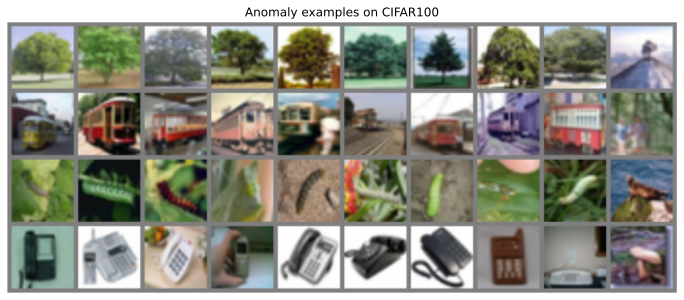

In [22]:
_, indices, _ = next(iter(test_anom_loader))
visualize_exmp(indices[:4], test_set)

In [25]:
anomaly_model, anomaly_result = train_anomaly(input_dim=train_anom_dataset.img_feats.shape[-1],
                                              model_dim=256,
                                              num_heads=4,
                                              num_classes=1,
                                              num_layers=4,
                                              dropout=0.1,
                                              input_dropout=0.1,
                                              lr=5e-4,
                                              warmup=100,
                                              train_anom_loader=train_anom_loader,
                                              val_anom_loader=val_anom_loader,
                                              test_anom_loader=test_anom_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: ../saved_models/tutorial6/SetAnomalyTask/lightning_logs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | input_net           | Sequential         | 131 K 
1 | positional_encoding | PositionalEncoding | 0     
2 | transformer         | TransformerEncoder | 2.1 M 
3 | output_net          | Sequential         | 66.6 K
-----------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.225     Total estimated model params size (MB)


Global seed set to 42


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/gsoykan20/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  warnings.warn(*args, **kwargs)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [26]:
print("Train accuracy: %4.2f%%" % (100.0*anomaly_result["train_acc"]))
print("Val accuracy:   %4.2f%%" % (100.0*anomaly_result["val_acc"]))
print("Test accuracy:  %4.2f%%" % (100.0*anomaly_result["test_acc"]))

Train accuracy: 98.76%
Val accuracy:   94.44%
Test accuracy:  95.12%


In [ ]:
## VERIFYING MODEL WORKS OR NOT BY SHOWING IT IS "permutation-equivariant"

In [27]:
inp_data, indices, labels = next(iter(test_anom_loader))
inp_data = inp_data.to(device)

anomaly_model.eval()

with torch.no_grad():
    preds = anomaly_model.forward(inp_data, add_positional_encoding=False)
    preds = F.softmax(preds.squeeze(dim=-1), dim=-1)

    # Permut input data
    permut = np.random.permutation(inp_data.shape[1])
    perm_inp_data = inp_data[:,permut]
    perm_preds = anomaly_model.forward(perm_inp_data, add_positional_encoding=False)
    perm_preds = F.softmax(perm_preds.squeeze(dim=-1), dim=-1)

assert (preds[:,permut] - perm_preds).abs().max() < 1e-5, "Predictions are not permutation equivariant"

print("Preds\n", preds[0,permut].cpu().numpy())
print("Permuted preds\n", perm_preds[0].cpu().numpy())

Preds
 [8.2981683e-07 9.0404853e-07 7.0636304e-07 6.4755875e-07 7.8031275e-07
 7.8484447e-07 9.9999332e-01 6.5665199e-07 6.9816429e-07 7.0285535e-07]
Permuted preds
 [8.2981842e-07 9.0405030e-07 7.0636440e-07 6.4755875e-07 7.8031422e-07
 7.8484601e-07 9.9999332e-01 6.5665324e-07 6.9816429e-07 7.0285671e-07]


In [28]:
attention_maps = anomaly_model.get_attention_maps(inp_data, add_positional_encoding=False)
predictions = preds.argmax(dim=-1)

In [29]:
def visualize_prediction(idx):
    visualize_exmp(indices[idx:idx+1], test_set)
    print("Prediction:", predictions[idx].item())
    plot_attention_maps(input_data=None, attn_maps=attention_maps, idx=idx)

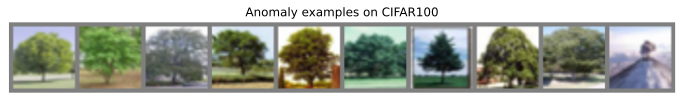

Prediction: 9


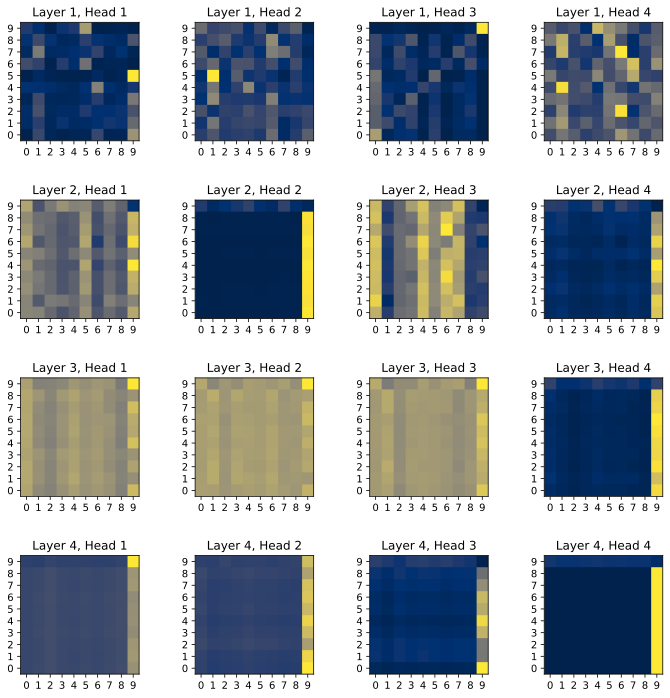

In [32]:
visualize_prediction(0)

In [33]:
mistakes = torch.where(predictions != 9)[0].cpu().numpy()
print("Indices with mistake:", mistakes)


Indices with mistake: [33 39]


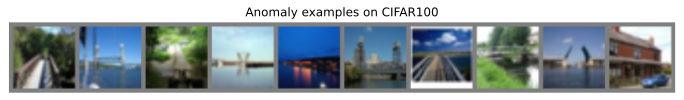

Prediction: 2


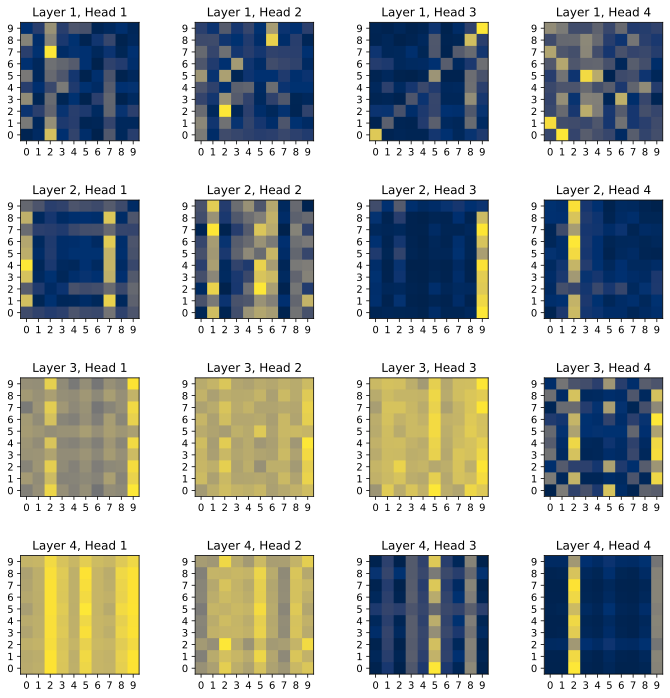

Probabilities:
Image 0: 2.55%
Image 1: 0.22%
Image 2: 52.77%
Image 3: 0.11%
Image 4: 0.20%
Image 5: 0.04%
Image 6: 0.22%
Image 7: 0.89%
Image 8: 0.06%
Image 9: 42.93%


In [34]:
visualize_prediction(mistakes[-1])
print("Probabilities:")
for i, p in enumerate(preds[mistakes[-1]].cpu().numpy()):
    print("Image %i: %4.2f%%" % (i, 100.0*p))
